In [2]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 30.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 70 kB 9.0 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
  Created wheel for pycuda: filename=pycuda-2022.1-cp37-cp37m-linux_x86_64.whl size=629484 sha256=f91277024ead74ea6ac9b7e1badea2524a500e7379705b62b05ef055e7bbe9cc
  Stored in directory: /root/.cache/pip/wheels/17/53/c9/caa05618e686df51f017d8a9923f38d915ce31df67ab6628e6
  Created wheel for pytools: filename=pytools-2022.1.12-py2.py3-none-any.whl size=65034 sha256=82066384c953c1bf568ef99b9c22773314fd4f18e1b993cacc1570251d8671ad
  Stored in directory: /root/.cache/pip/wheels/37/5e/9e/76d7430e116b7cab0016fbabb26b896daae1946a3f7dea9915
Successfully built pycuda pytools


In [3]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math

In [108]:
class Shared:
    def __init__(self, A, b, learning_rate):
        ## input matrix's shape
        self.length = A.shape[0]
        self.width = A.shape[1]
        
        ## in CPU
        self.A = np.float32(A)
        self.b = np.float32(b)
        self.theta = np.float32(np.zeros(self.width))
        self.out = np.float32(np.zeros(self.length))
        self.grad = np.float32(np.zeros(self.width))

        ## in GPU
        self.GPU_A = gpuarray.to_gpu(self.A.reshape(self.length*self.width))
        self.GPU_b = gpuarray.to_gpu(self.b)
        self.GPU_theta = gpuarray.to_gpu(self.theta)
        self.GPU_out = gpuarray.to_gpu(self.out)
        self.GPU_grad = gpuarray.to_gpu(self.grad)

        ## for initialize out vector and grad vector
        self.init_out = gpuarray.empty_like(self.GPU_out)
        self.init_grad = gpuarray.empty_like(self.GPU_grad)

        ## TPB: thread_per_block, BPG: block_per_grid        
        self.TPB, self.BPG = self.optimal_block_size(self.length)

        ## learning_rate
        self.learning_rate = learning_rate

    def optimal_block_size(self, n):
        
        thread_per_block = int(math.sqrt(n / 2))

        block_per_grid = int(n / thread_per_block) + 1


        return thread_per_block, block_per_grid

In [80]:
class GetGradient:
    def __init__(self, shared):
       self.shared = shared
       
       self.kernel_function()

    def run(self):

        self.initialize()

        ## get out = np.dot(A, theta) - b
        self.first(self.shared.GPU_out,
                   self.shared.GPU_A,
                   self.shared.GPU_theta,
                   self.shared.GPU_b,
                   np.int32(self.shared.length),
                   np.int32(self.shared.width),
                   block=(self.shared.TPB,1,1),
                   grid=(self.shared.BPG,1,1))

        ## get grad = np.dot(A.T, out)
        self.second(self.shared.GPU_grad,
                   self.shared.GPU_A,
                   self.shared.GPU_out,
                   np.int32(self.shared.TPB),
                   np.int32(self.shared.BPG),
                   np.int32(self.shared.length),
                   np.int32(self.shared.width),
                   block=(self.shared.BPG,1,1),
                   grid=(self.shared.width,1,1))
                   
                   

    def kernel_function(self):
        ## block=(thread_per_block,1,1), grid=(block_per_grid,1,1)
        first_ker_function = \
        """
        #define x (threadIdx.x + blockIdx.x * blockDim.x)

        __global__ void first(float* out, float* A, float* theta, float* b, int length, int width) {
            
            if (x < length) {
                for (int j = 0; j < width; j++) {
                    int index1 = x * width + j;

                    out[x] += A[index1] * theta[j];
                    }

                out[x] -= b[x];
            }
        }
        """
        first_ker = SourceModule(first_ker_function)



        ## block=(block_per_grid,1,1), grid=(width,1,1)
        second_ker_function = \
        """
        #define tx (threadIdx.x)
        #define bx (blockIdx.x)

        __global__ void second(float* grad, float* A, float* out, int thread_per_block, int block_per_grid, int length, int width) {

            __shared__ float grad_jerk[1000];

            grad_jerk[tx] = 0;

            __syncthreads();
            
            for (int i = 0; i < thread_per_block; i++) {
                int index1 = tx * thread_per_block + i;
                int index2 = index1 * width + bx;
                
                grad_jerk[tx] += A[index2] * out[index1];
            }

            __syncthreads();

            if (tx == 0) {
                for (int i = 0; i < block_per_grid; i++) {
                    grad[bx] += grad_jerk[i];
                }
            }
            else {
                grad_jerk[1000-tx] = 0;
            }

            __syncthreads();
        }
        """
        second_ker = SourceModule(second_ker_function)

        self.first = first_ker.get_function("first")
        self.second = second_ker.get_function("second")

    def initialize(self):
        self.shared.GPU_out[:] = self.shared.init_out[:]
        self.shared.GPU_grad[:] = self.shared.init_grad[:]

In [6]:
class Optimizer:
    def __init__(self, shared):
        self.shared = shared

        self.kernel_function()

    def run(self):
        return NotImplementedError()

    def kernel_function(self):
        return NotImplementedError()
        


class GradientMethod(Optimizer):
    def __init__(self, shared):
        Optimizer.__init__(self, shared)

    def run(self):

        self.gradient_method(self.shared.GPU_theta,
                             self.shared.GPU_grad,
                             np.float32(self.shared.learning_rate),
                             block=(self.shared.width,1,1),
                             grid=(1,1,1))

    def kernel_function(self):

        ## block=(width,1,1), grid=(1,1,1)
        gradient_method_ker = SourceModule(
            """
            #define x (threadIdx.x)

            __global__ void gradient_method (float* theta, float* grad, float learning_rate) {
                theta[x] -= learning_rate * grad[x];

                __syncthreads();
            }
            """
        )

        self.gradient_method = gradient_method_ker.get_function("gradient_method")



class MomentumMethod(Optimizer):
    def __init__(self, shared):
        Optimizer.__init__(self, shared)

    def run(self):

        self.momentum_method(self.shared.GPU_theta,
                             self.shared.GPU_grad,
                             self.shared.GPU_momentum,
                             np.float32(self.shared.s),
                             np.float32(self.shared.beta),
                             block=(self.shared.width,1,1),
                             grid=(1,1,1))

    def kernel_function(self):

        ## block=(width,1,1), grid=(1,1,1)
        momentum_method_ker = SourceModule(
            """
            #define x (threadIdx.x)

            __global__ void momentum_method (float* theta, float* grad, float* momentum, float s, float beta) {
                theta[x] -= s * momentum[x];

                momentum[x] = grad[x] + beta * momentum[x];

                __syncthreads();
            }
            """
        )
        
        self.momentum_method = momentum_method_ker.get_function("momentum_method")

In [138]:
A = np.random.randn(1000,20)
b = np.random.randn(1000)
learning_rate = 2e-4

shared = Shared(A, b, learning_rate)

get_gradient = GetGradient(shared)

get_gradient.run()

gradient_method = GradientMethod(shared)

gradient_method.run()

In [140]:
grad_cpu = np.dot(A.T, (np.dot(A, np.zeros(A.shape[1])) - b))
print(np.linalg.norm(shared.GPU_grad.get() - grad_cpu))

print(np.linalg.norm(shared.GPU_theta.get() - (np.zeros(A.shape[1]) - learning_rate * grad_cpu)))

2.1118094515521284e-05
4.374422449058345e-09


In [152]:
class LeastSquare:
    def __init__(self, A, b, learning_rate, epoches=10, iteration=10, optimize_method="GD"):
        ## shared
        self.shared = Shared(A, b, learning_rate)

        ## gradient
        self.get_gradient = GetGradient(self.shared)

        ## optimizer
        self.optimizer = GradientMethod(self.shared)

        ## epoches, iteration
        self.epoches = epoches
        self.iteration = iteration

        ## error log
        self.error = np.zeros(epoches)

    def solve(self):
        for epoch in range(self.epoches):
            for iter in range(self.iteration):
                ## get gradient
                self.get_gradient.run()

                ## optimize
                self.optimizer.run()

            self.record_error(epoch)

    def record_error(self, epoch):

        self.error[epoch] = np.linalg.norm(self.shared.GPU_out.get())

# Test

In [153]:
A = np.random.rand(1000,20)
b = np.random.rand(1000)
learning_rate = 2e-4

Duration: 0.012130498886108398


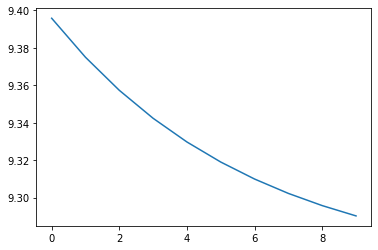

9.290304183959961


In [154]:
lstsq = LeastSquare(A, b, learning_rate, iteration=5)

t1 = time()

lstsq.solve()

t2 = time()

print(f"Duration: {t2 - t1}")

plt.plot(lstsq.error)
plt.show()

print(lstsq.error[-1])

In [155]:
t1 = time()
opt_theta = np.linalg.lstsq(A,b, rcond=None)[0]
t2 =time()

print(f"Duration: {t2 - t1}")

print(np.linalg.norm(np.dot(A, opt_theta) - b))

Duration: 0.0023779869079589844
9.259577915299033


In [156]:
A = np.random.randn(2000,20)
b = np.random.randn(2000)
learning_rate = 2e-4

Duration: 0.010039567947387695


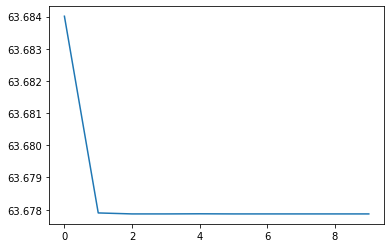

63.6778678894043


In [159]:
lstsq = LeastSquare(A, b, learning_rate, iteration=5)

t1 = time()

lstsq.solve()

t2 = time()

print(f"Duration: {t2 - t1}")

plt.plot(lstsq.error)
plt.show()

print(lstsq.error[-1])

In [160]:
t1 = time()
opt_theta = np.linalg.lstsq(A,b, rcond=None)[0]
t2 =time()

print(f"Duration: {t2 - t1}")

print(np.linalg.norm(np.dot(A, opt_theta) - b))

Duration: 0.0032167434692382812
44.21644723260087


In [168]:
A = np.random.rand(3000,50)
b = np.random.rand(3000)
learning_rate = 1e-5

Duration: 0.009729862213134766


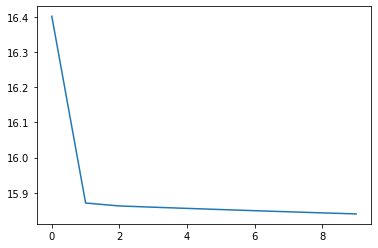

15.840067863464355


In [169]:
lstsq = LeastSquare(A, b, learning_rate, iteration=5)

t1 = time()

lstsq.solve()

t2 = time()

print(f"Duration: {t2 - t1}")

plt.plot(lstsq.error)
plt.show()

print(lstsq.error[-1])

In [170]:
t1 = time()
opt_theta = np.linalg.lstsq(A,b, rcond=None)[0]
t2 =time()

print(f"Duration: {t2 - t1}")

print(np.linalg.norm(np.dot(A, opt_theta) - b))

Duration: 0.011057853698730469
15.720925929156069


# Test 2